In [ ]:
from seeq import spy
import pandas as pd

## Example Data
This template code shows how an asset tree, that fulfills the requirements of the Constraint Detection Add-on, can be generated from data that is already in Seeq. The Constraint Detection Add-on requires a layout where all assets on the bottom of the hierarchy are controllers. All signals linked to one controller must be either a 'Controller Output', a 'Setpoint', a 'Process Variable', a 'Mode' or a 'Manipulated Variable'. The correct naming is of high importance and other signal types won't be processed by the Add-on. For this demonstration, the Example asset tree will be used since it is available to every Seeq user. The Example asset tree does not contain any control loop data. This code should only demonstrate how data from Seeq can be transferred to an asset structure that can be interpreted by the Constraint Detection Add-on.

With `spy.search`, the metadata of all signals in 'Cooling Tower 1' can be obtained. The metadata is used to build the asset tree. In this example, an asset tree with 8 Controllers will be generated.
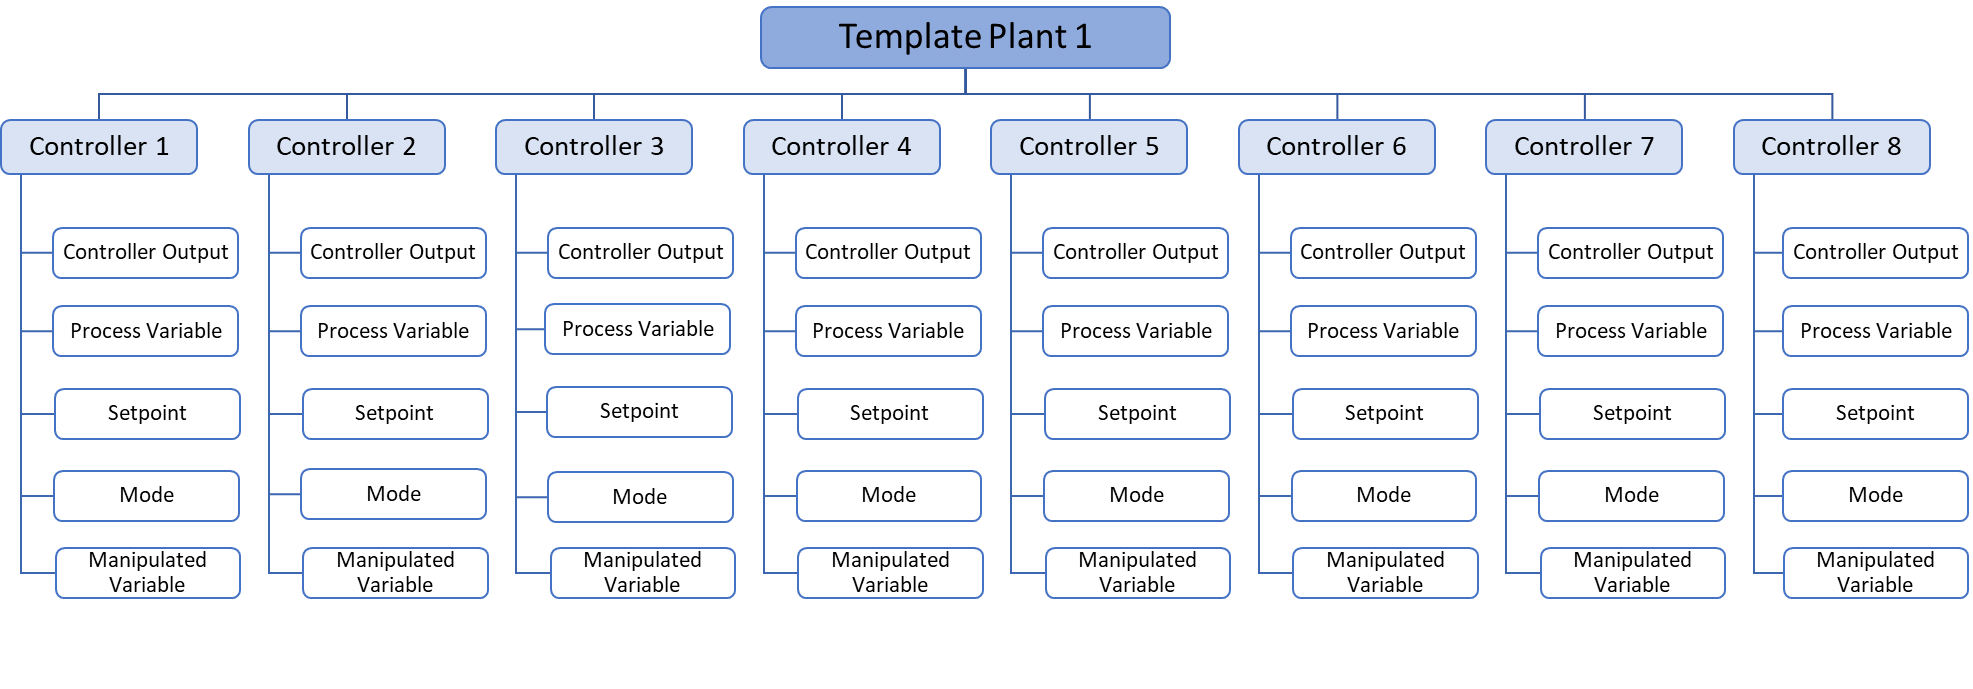

In [ ]:
# search for signals in Cooling Tower 1
items = spy.search({
    'Path': 'Example >> Cooling Tower 1',
    'Type': 'Signal'})

items = items[items['Value Unit Of Measure']!='string']
items = items.reset_index(drop=True)
items.head()

## Build Assets and Paths¶
To build an asset tree, a `Build Asset` and `Build Path` column have to be defined in the metadata. More information on this topic can be found in the `spy.assets` documentation (https://python-docs.seeq.com/user_guide/spy.assets/index.html). To use the Constraint Detection Add-on, the `Build Asset` column must specify a controller. In this example, every area in the 'Cooling Tower 1' asset will be converted to a controller. Any other naming for the controller assets is accepted by the Add-on. For example, you could use "FIC103" or "Reactor Temperature Control" as a name for the `Build Asset` column. The `Build Path` column points to your controller asset. It can be defined for every signal individually. Here, all controllers will be found under the same path 'Template Plant 1'. 

In [ ]:
# generate the Build Path column
items['Build Path'] = 'Template Plant 1'
# generate an empty Build Asset column
items['Build Asset'] = ''

# loop through the metadata fill the Build Asset column
for i in range(len(items.index)):
    if 'Area A' in items['Asset'][i]:
        items.loc[i, 'Build Asset'] = 'Controller 1'
    if 'Area B' in items['Asset'][i]:
        items.loc[i, 'Build Asset'] = 'Controller 2'
    if 'Area C' in items['Asset'][i]:
        items.loc[i, 'Build Asset'] = 'Controller 3'
    if 'Area G' in items['Asset'][i]:
        items.loc[i, 'Build Asset'] = 'Controller 4'
    if 'Area H' in items['Asset'][i]:
        items.loc[i, 'Build Asset'] = 'Controller 5'
    if 'Area I' in items['Asset'][i]:
        items.loc[i, 'Build Asset'] = 'Controller 6'
    if 'Area J' in items['Asset'][i]:
        items.loc[i, 'Build Asset'] = 'Controller 7'
    if 'Area K' in items['Asset'][i]:
        items.loc[i, 'Build Asset'] = 'Controller 8'
        
items.head()

In [ ]:
# the old path and asset can be dropped from the dataframe
items.drop(['Path', 'Asset'], axis=1, inplace=True)

## Asset Structure Class
spy.assets requires a class that defines the attributes which can be connected to an asset. Since all the assets in the asset structure should be controllers, the attributes will be control signals: Controller output, setpoint, auto manual mode, process variable and manipulated variable. The names of the attributes must not be changed, as this naming is required for the Constraint Detection Add-on. Instead, the returned signals need to be adapted so that they fit your data.
Since the Example asset tree does not contain any control loop data, the signals will be randomly assigned as follows (for the purpose of demonstration):

Controller Output -> Compressor Power

Setpoint -> Optimizer

Mode -> Relative Humidity

Process Variable -> Temperature

Manipulated Variable -> Wet Bulb

In [ ]:
from seeq.spy.assets import Asset, ItemGroup

class AssetStructureClass(Asset):
    
    @Asset.Attribute()
    def Controller_Output(self, metadata):
        df = metadata[metadata['Name'].str.endswith('Compressor Power')]
        return df
    
    @Asset.Attribute()
    def Setpoint(self, metadata):
        df = metadata[metadata['Name'].str.endswith('Optimizer')]
        return df
    
    @Asset.Attribute()
    def Mode(self, metadata):
        df = metadata[metadata['Name'].str.endswith('Relative Humidity')]
        return df
    
    @Asset.Attribute()
    def Process_Variable(self, metadata):
        df = metadata[metadata['Name'].str.endswith('Temperature')]
        return df
    
    @Asset.Attribute()
    def Manipulated_Variable(self, metadata):
        df = metadata[metadata['Name'].str.endswith('Wet Bulb')]
        return df

# Metadata
Using the `spy.assets.build` function, the asset structure is generated from the class and the defined `Build Asset` and `Build Path` column. If there are attributes which cannot be matched to the metadata, the function will throw an error. In this case all signals got matched successfully. The finished asset structure can be pushed to the workbench.

In [ ]:
metadata_asset_structure = spy.assets.build(AssetStructureClass, metadata = items)

In [ ]:
spy.push(metadata=metadata_asset_structure)